<a href="https://colab.research.google.com/github/bhavanabommana12/vehicle-detection/blob/main/Copy_of_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm

# Display image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline


In [ ]:
path = "/content/test10s.mp4"

In [ ]:
frac = 0.65
display(Video(data=path, height=int(720*frac), width=int(1280*frac)))

In [ ]:
#loading a YOLO model
model = YOLO('yolov8x.pt')

#geting names from classes
dict_classes = model.model.names

In [ ]:
# Auxiliary functions
def risize_frame(frame, scale_percent):
    """Function to resize an image in a percent scale"""
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    return resized

In [ ]:
# # Getting predictions
y_hat = model.predict(frame, conf=0.7, classes=class_IDS, device='cpu', verbose=False)


Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
### Configurations
#Verbose during prediction
verbose = False
# Scaling percentage of original frame
scale_percent = 50


#-------------------------------------------------------
# Reading video with cv2
video = cv2.VideoCapture(path)

# Objects to detect Yolo
class_IDS = [2, 3, 5, 7]
# Auxiliary variables
centers_old = {}
centers_new = {}
obj_id = 0


end = []
frames_list = []
cy_linha = int(1500 * scale_percent/100 )
cx_sentido = int(2000 * scale_percent/100)
offset = int(8 * scale_percent/100 )

print(f'[INFO] - Verbose during Prediction: {verbose}')

# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))
    #-------------------------------------------------------
### Video output ####
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(tmp_output_path,
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                               fps, (width, height))

#-------------------------------------------------------
# Executing Recognition
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):

    # reading frame from video
    _, frame = video.read()

    #Applying resizing of read frame
    frame  = risize_frame(frame, scale_percent)

    if verbose:
        print('Dimension Scaled(frame): ', (frame.shape[1], frame.shape[0]))
        # Getting predictions
    y_hat = model.predict(frame, conf = 0.7, classes = class_IDS, device = 0, verbose = False)

    # Getting the bounding boxes, confidence and classes of the recognize objects in the current frame.
    boxes   = y_hat[0].boxes.xyxy.cpu().numpy()
    conf    = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy()



    # Create a DataFrame
    positions_frame = pd.DataFrame({
        'xmin': boxes[:, 0],
        'ymin': boxes[:, 1],
        'xmax': boxes[:, 2],
        'ymax': boxes[:, 3],
        'conf': conf,
        # confidences,
        'class': classes
    })

    #Translating the numeric class labels to text
    labels = [dict_classes[i] for i in classes]

    # Drawing transition line for in\out vehicles counting
    cv2.line(frame, (0, cy_linha), (int(4500 * scale_percent/100 ), cy_linha), (255,255,0),8)
     # For each vehicles, draw the bounding-box and counting each one the pass thought the transition line (in\out)
    for ix, row in enumerate(positions_frame.iterrows()):
        # Getting the coordinates of each vehicle (row)
        xmin, ymin, xmax, ymax, confidence, category,  = row[1].astype('int')

        # Calculating the center of the bounding-box
        center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)

        # drawing center and bounding-box of vehicle in the given frame
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 5) # box
        cv2.circle(frame, (center_x,center_y), 5,(255,0,0),-1) # center of box

        #Drawing above the bounding-box the name of class recognized.
        cv2.putText(img=frame, text=labels[ix]+' - '+str(np.round(conf[ix],2)),
                    org= (xmin,ymin-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=2)


    if verbose:
        print(contador_in, contador_out)
    #Saving frames in a list
    frames_list.append(frame)
    #saving transformed frames in a output video formaat
    output_video.write(frame)

#Releasing the video
output_video.release()
####  pos processing
# Fixing video output codec to run in the notebook\browser
if os.path.exists(output_path):
    os.remove(output_path)

subprocess.run(
    ["ffmpeg",  "-i", tmp_output_path,"-crf","18","-preset","veryfast","-hide_banner","-loglevel","error","-vcodec","libx264",output_path])
os.remove(tmp_output_path)

[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (1280, 720)
[INFO] - Scaling change may cause errors in pixels lines 
[INFO] - Dim Scaled:  (640, 360)


  0%|          | 0/253 [00:00<?, ?it/s]

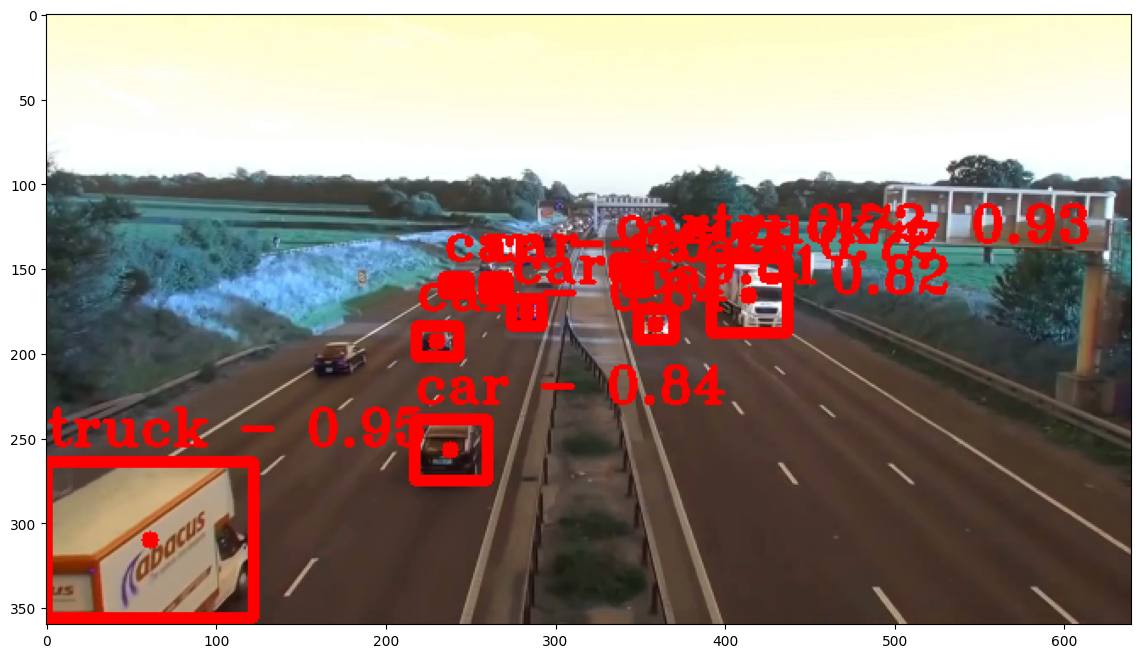

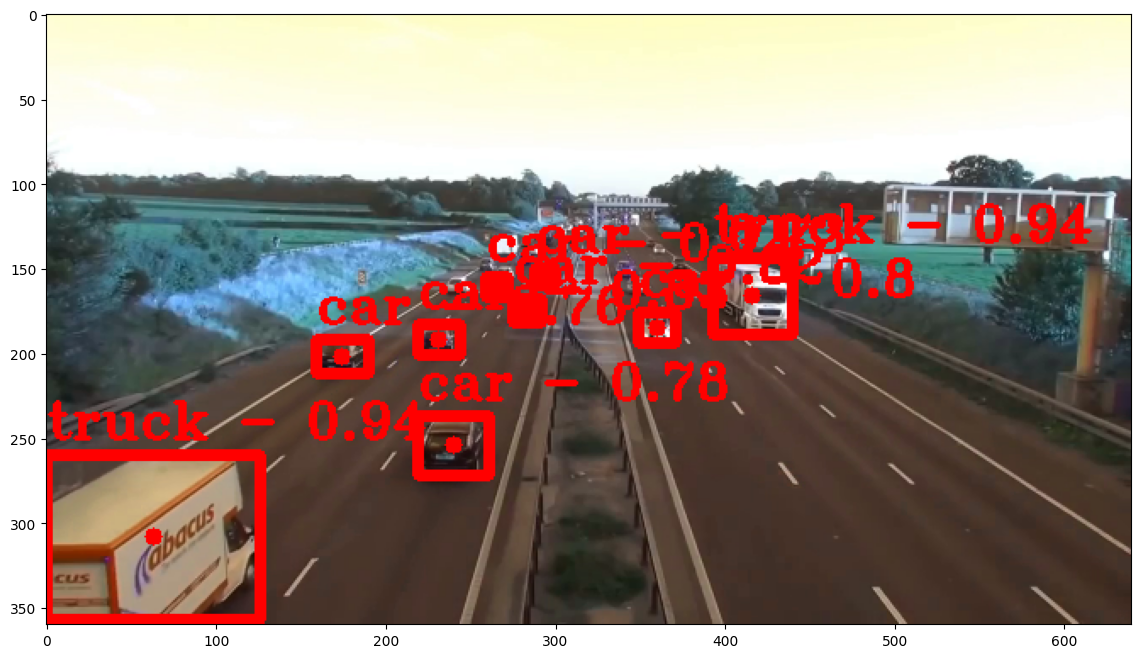

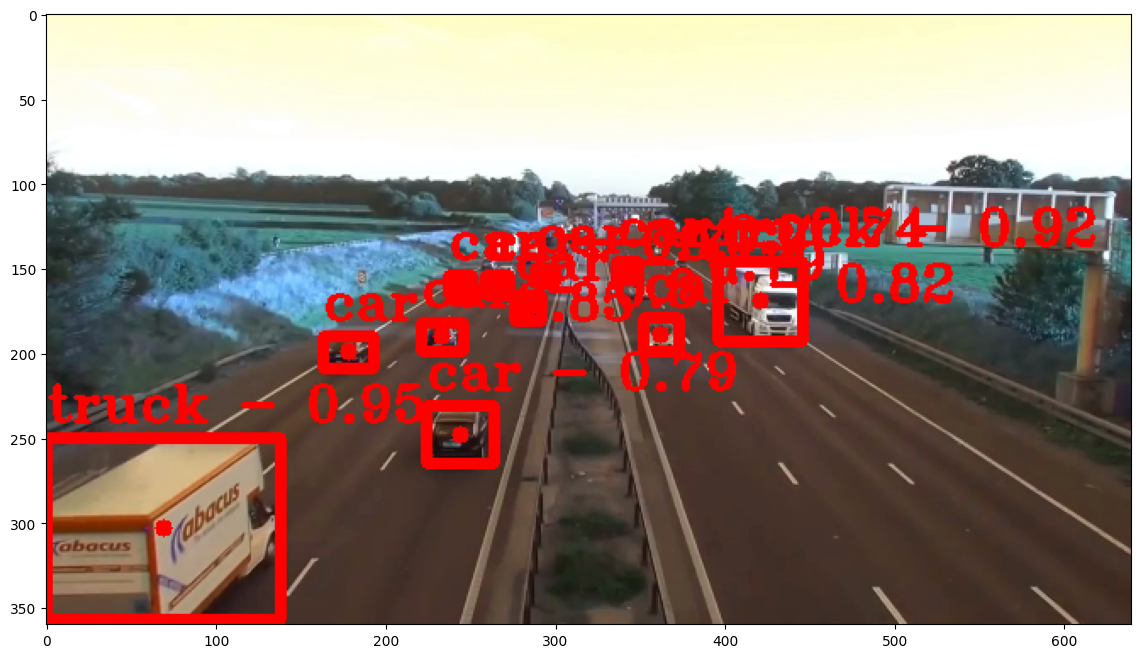

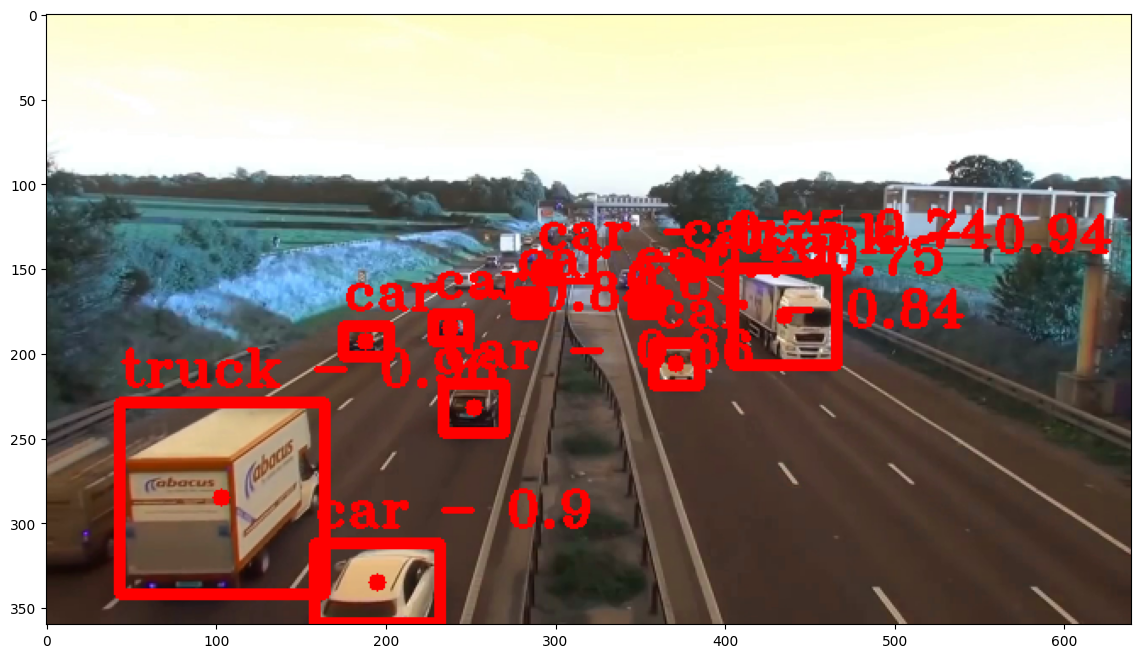

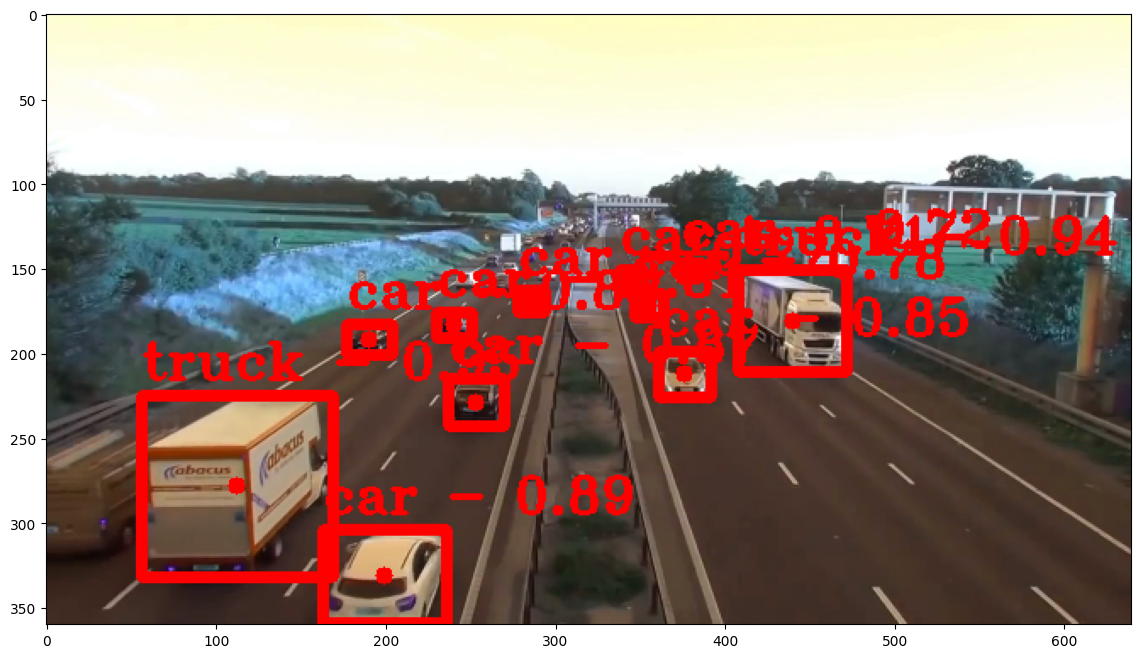

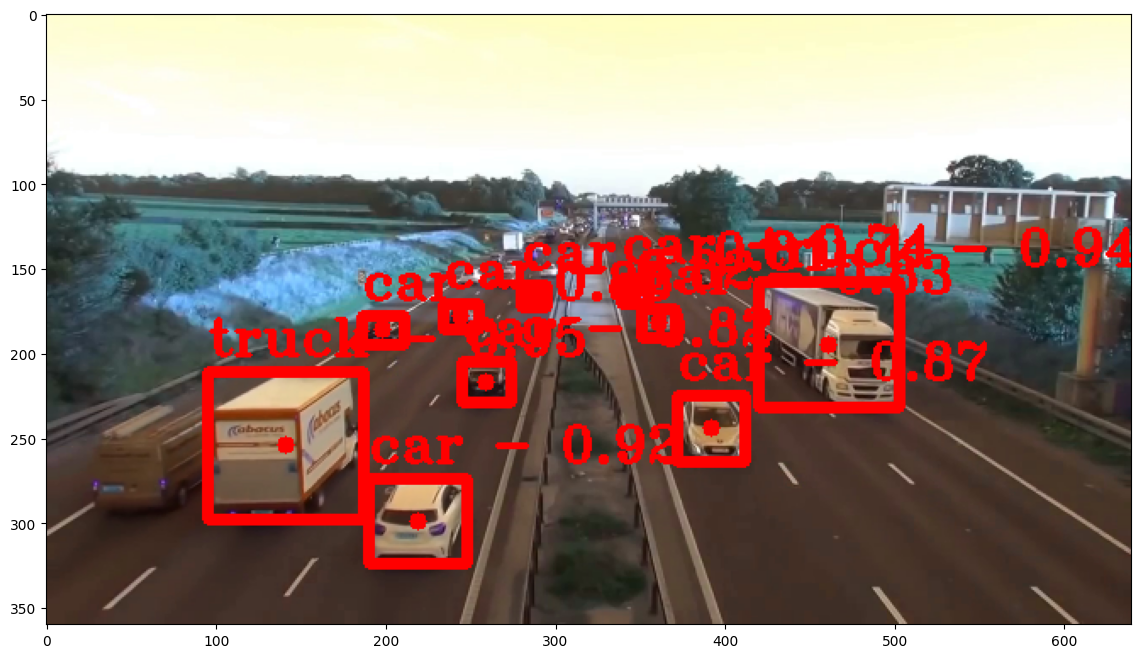

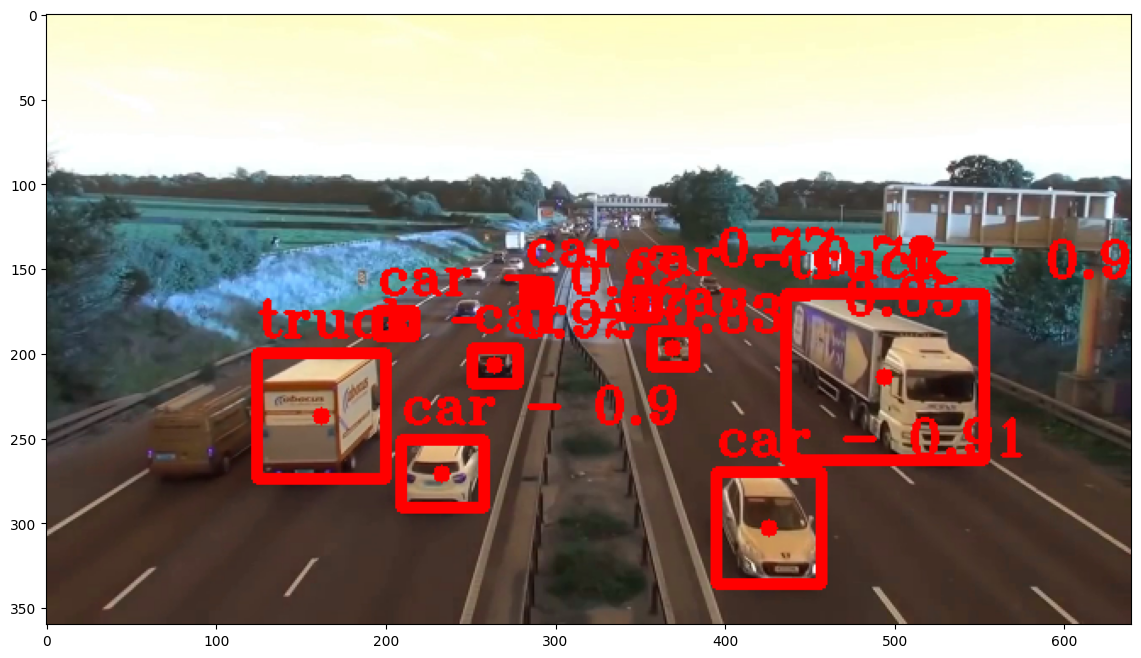

In [ ]:
for i in [28, 29, 32, 40, 42, 50, 58]:
    plt.figure(figsize =( 14, 10))
    plt.imshow(frames_list[i])
    plt.show()

In [ ]:
#output video result
frac = 0.7
Video(data='rep_result.mp4', embed=True, height=int(720 * frac), width=int(1280 * frac))